In [78]:
!pip install google_images_download

     |████████████████████████████████| 911kB 4.6MB/s eta 0:00:01
  Stored in directory: /localhome/volodin/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [82]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from model_conv import *
from experiment_model import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np
from IPython.display import Image, display

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation

# loading resnet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


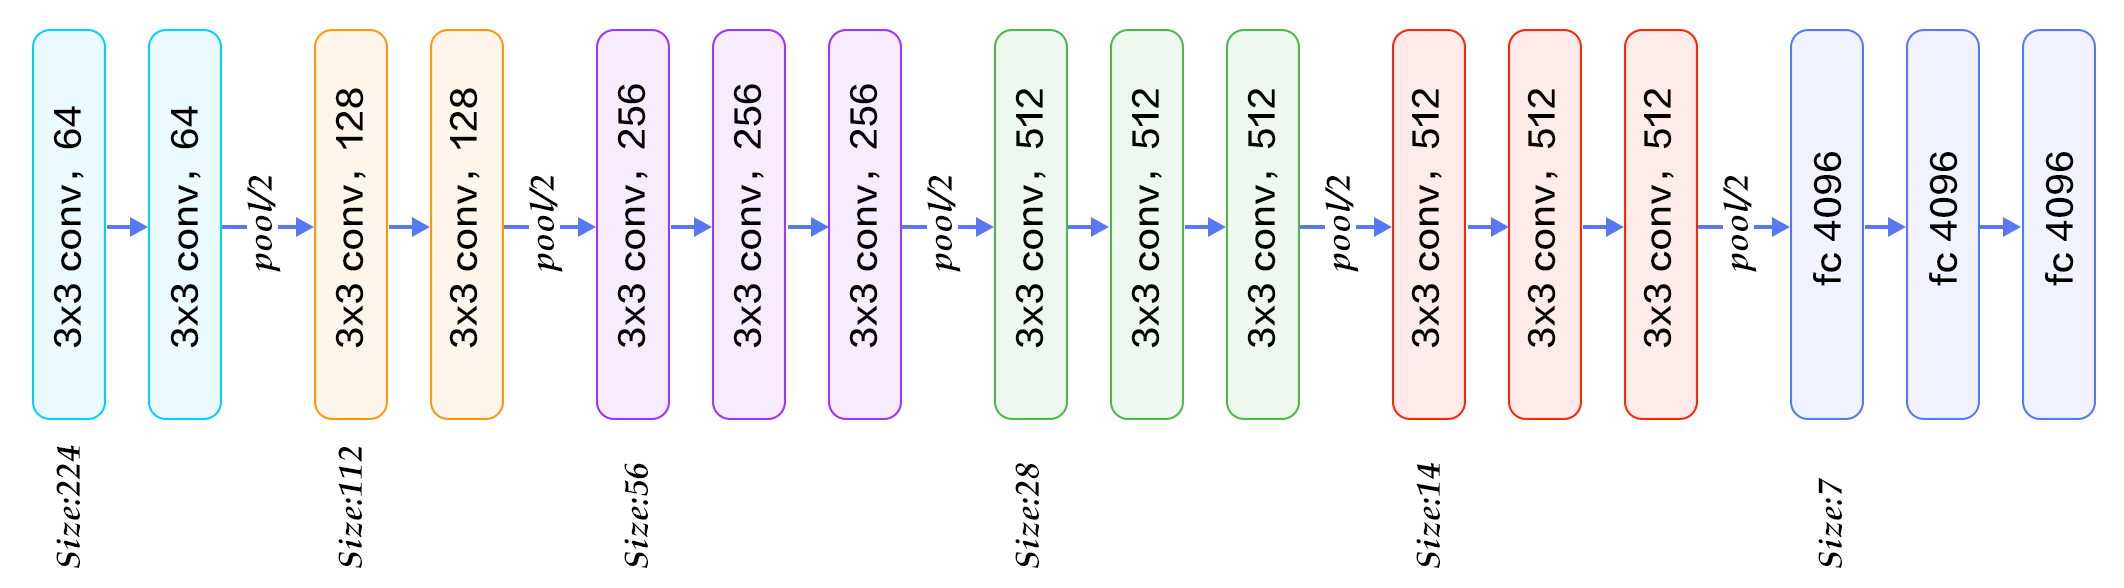

In [83]:
# creating vgg16 model
model = VGG16(weights = 'imagenet')

In [84]:
# replacing ReLU with Softplus(2)
model = replace_relu_with_softplus(model, scaler = 2.0)

Replacing ReLU to Softplus(2.00)
Replacing activation relu on layer 1/<keras.layers.convolutional.Conv2D object at 0x7f73db5c14a8> with softplus
Replacing activation relu on layer 2/<keras.layers.convolutional.Conv2D object at 0x7f73db5c17b8> with softplus
Replacing activation relu on layer 4/<keras.layers.convolutional.Conv2D object at 0x7f73db5b4940> with softplus
Replacing activation relu on layer 5/<keras.layers.convolutional.Conv2D object at 0x7f73db567668> with softplus
Replacing activation relu on layer 7/<keras.layers.convolutional.Conv2D object at 0x7f73db56a978> with softplus
Replacing activation relu on layer 8/<keras.layers.convolutional.Conv2D object at 0x7f73db57e128> with softplus
Replacing activation relu on layer 9/<keras.layers.convolutional.Conv2D object at 0x7f73db205780> with softplus
Replacing activation relu on layer 11/<keras.layers.convolutional.Conv2D object at 0x7f73db224f60> with softplus
Replacing activation relu on layer 12/<keras.layers.convolutional.Conv

/localhome/volodin/miniconda3/envs/rl/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [85]:
# output layer
l = -1

# choosing only this output layer
model_cut = cut_and_flatten(model, l)

In [5]:
# inactive
#d = 10
#model_upscale = upscale_from(model_cut, d)

In [80]:
!googleimagesdownload --keywords "Cat,dog" --limit 20


Item no.: 1 --> Item name = Cat
Evaluating...
Starting Download...
Invalid or missing image format. Skipping...
Completed Image ====> 1.An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg
Completed Image ====> 2.02-cat-training-NationalGeographic_1484324.jpg
Completed Image ====> 3.tesla-cat.jpg
Completed Image ====> 4.152964589-welcome-home-new-cat-632x475.jpg
Completed Image ====> 5.choosing-a-cat.jpg
Completed Image ====> 6.creepy-cat.jpg
Completed Image ====> 7.5acb63d83493f__700-png.jpg
Completed Image ====> 8.what-does-it-mean-when-cat-wags-tail.jpg
Completed Image ====> 9.cataccessories-lowres-2x1-05916.jpg
Completed Image ====> 10.maxresdefault.jpg
Completed Image ====> 11.578211-gettyimages-542930526.jpg
Completed Image ====> 12.67586673.jpg
Invalid or missing image format. Skipping...
Completed Image ====> 13.1200px-Cat03.jpg
Completed Image ====> 14.cat-cloning_resize_md.jpg
Completed Image ====> 15.cat-4262034_1280-e1561555501321.jpg
Completed Image ====

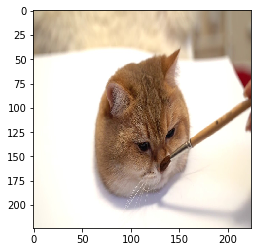

In [89]:
# loading the cat image
x = load_image('downloads/Cat/10.maxresdefault.jpg')

In [111]:
# making only 10 entries in the red channel column 0 faulty
#rc0 = 10
#x, x_without_first = split_x_rc0(x, rc0 = rc0)

In [112]:
# create a model which adds the rest
model_upscale = merge_with_taken(model_cut, x_without_first, rc0 = rc0)
#model_upscale = model_cut

In [113]:
if l == -1:
    print(decode_predictions(model_upscale.predict(x), top=3)[0])
else:
    print(model_upscale.predict(x))

[('n02124075', 'Egyptian_cat', 0.33523816), ('n02123045', 'tabby', 0.08931073), ('n03794056', 'mousetrap', 0.08121984)]


In [120]:
# probability of input failure
p = 0.01

In [121]:
# calculating np
n = np.prod(list(map(int, model_upscale.inputs[0].shape[1:])))
n, n * p

(10, 0.1)

In [122]:
# keeping indices with the largest output probability
top_predictions = 10
to_keep = np.array(np.argsort(-model_upscale.predict(x))[0][:top_predictions], dtype = np.int32)

In [123]:
print('Keeping output indices ' + ', '.join([str(t) for t in to_keep]))

Keeping output indices 285, 281, 674, 287, 286, 284, 457, 783, 604, 677


In [124]:
# model with only these indices kept
model_slice = keep_oindices(model_upscale, to_keep)

In [125]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model_slice, p = p)

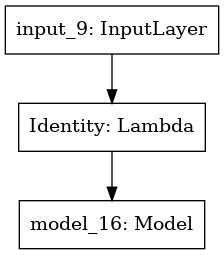

In [126]:
# showing correct/crashing models
display(Image(model_to_dot(exp.model_correct, ).create(prog='dot', format='png'), width = 80))

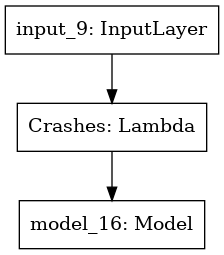

In [127]:
display(Image(model_to_dot(exp.model_crashing).create(prog='dot', format='png'), width = 80))

In [132]:
# crashing prediction
decode_predictions(predict_kept(exp.model_crashing, x, to_keep), top=3)[0]

[('n02124075', 'Egyptian_cat', 0.33523809909820557),
 ('n02123045', 'tabby', 0.08931071311235428),
 ('n03794056', 'mousetrap', 0.08121982216835022)]

In [133]:
# correct prediction
decode_predictions(predict_kept(exp.model_correct, x, to_keep), top=3)[0]

[('n02124075', 'Egyptian_cat', 0.33523815870285034),
 ('n02123045', 'tabby', 0.08931072801351547),
 ('n03794056', 'mousetrap', 0.08121983706951141)]

In [134]:
# get theoretical error (bound b3)
theoretical = exp.get_bound_b3(x)

In [136]:
# get experimental error
experimental = experiment_mean_std(exp, x, repetitions = 1000)

In [137]:
theoretical['mean']

array([ 2.9725739e-04, -7.0873705e-07, -8.3003477e-05, -5.8022670e-06,
        5.0142076e-05, -1.6387241e-05, -3.8577866e-05,  3.5419355e-06,
       -2.5425914e-05, -8.4767436e-07], dtype=float32)

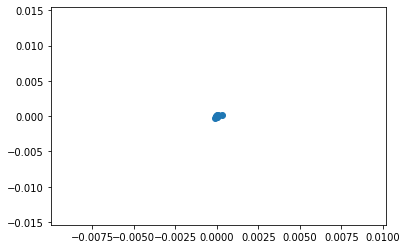

In [138]:
#plt.axes().set_aspect('equal')
#xs = np.linspace(-0.001, 0.001, 10)
#plt.plot(xs, xs)
plt.scatter(theoretical['mean'], experimental['mean'])

In [139]:
np.linalg.norm(theoretical['mean'] - experimental['mean']) / np.linalg.norm(experimental['mean'])

0.70197505

In [140]:
np.linalg.norm(theoretical['std'] - experimental['std']) / np.linalg.norm(experimental['std'])

0.5868033

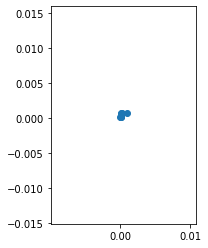

In [143]:
plt.axes().set_aspect('equal')
xs = np.linspace(0, 0.04, 10)
#plt.plot(xs, xs)
plt.scatter(theoretical['std'], experimental['std'])